Modeling the brusselator

Brusselator:

$$\dot u = D_0\triangle u +a - (b+1)u + u^2v$$
$$ \dot v = D_1\triangle v + bu - u^2v$$
or in other words

$$\dot u = D_0\triangle u +f_u$$
$$ \dot v = D_1\triangle v +f_v$$

In [114]:
import numpy as np
from scipy.fft import fftn, ifftn, fftfreq
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import cm
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from matplotlib import rc
import matplotlib.animation as animation
%matplotlib inline

def create_initial_array(num_of_nodes, ampl = 0.1):
    #return initial concentration of substance. Can be random, should be positive
    return np.random.rand(num_of_nodes,num_of_nodes) * ampl
# for now
class Brusselator():
    def __init__(self,N = 100, L = 40*np.pi, a=1.5, b=2.34, D0=2.8, D1=22.4, NUM_STEPS=10**4, dt = 0.05, method = 'pseudo-spectral'):
        self.N = N
        self.L = L
        self.a = a
        self.b = b
        self.D0 = D0
        self.D1 = D1
        self.NUM_STEPS = NUM_STEPS
        self.dt = dt
        fu = lambda u,v: a + (u**2)*v - (b+1)*u
        fv = lambda u,v: b*u-(u**2)*v
        self.fu = fu
        self.fv = fv
        self.method = method
        self.initial_data_u = create_initial_array(self.N)
        self.initial_data_v = create_initial_array(self.N)
    def update_initial_data(new_data_u, new_data_v):
        self.initial_data_u = new_data_u
        self.initial_data_v = new_data_v
        self.N = new_data_u.shape[0]
    # def get_equation_parameters(self):
    #     return \
    #     self.a,\
    #     self.b,\
    #     self.D0,\
    #     self.D1
    # def get_simulation_parameters(self):
    #     return \
    #     self.N,\
    #     self.L,\
    #     self.NUM_STEPS,\
    #     self.dt
    # def get_function(self):
    #     return self.fu, self.fv
    # def get_method(self):
    #     return self.method

In [115]:

def create_wavenumber_array(num_modes, L):
    # create array for wavenumbers in scipy format.
    num_modes = num_modes - num_modes%2 # make num of nodes even. Why?
    wavenum_array = np.zeros(num_modes)
    wavenum = 2*np.pi/L
    p1 = np.array([(wavenum * i) for i in range(int(num_modes/2))])
    p2 = np.array([wavenum * (-num_modes+n) for n in range(int(num_modes/2), num_modes)])
    wavenum_array = np.concatenate((p1,p2))
    return wavenum_array

def create_time_operator(wavenums, diffusion_coeff, timestep):
    ## create a time evolution operator
    wavenums = wavenums**2
    wavenums_sq = wavenums[:, np.newaxis] + wavenums[np.newaxis, :]
    # wavenums_sq = wavenums[:, np.newaxis]+wavenums
    operator = np.exp((-wavenums_sq)*timestep*diffusion_coeff)
    return operator

def apply_step_fourier(u,operator):
        fft_u = fftn(u)
        fft_u = fft_u*operator
        return ifftn(fft_u).real

def laplacian(Z, dx):
    Ztop = Z[0:-2, 1:-1]
    Zleft = Z[1:-1, 0:-2]
    Zbottom = Z[2:, 1:-1]
    Zright = Z[1:-1, 2:]
    Zcenter = Z[1:-1, 1:-1]
    return (Ztop + Zleft + Zbottom + Zright -
            4 * Zcenter) / dx**2
# von Neumann boundary conditions (no penetration)
def apply_boundary_condition(Z):
    Z[0, :] = Z[1, :]
    Z[-1, :] = Z[-2, :]
    Z[:, 0] = Z[:, 1]
    Z[:, -1] = Z[:, -2]
    return Z
     
## according to GPT it is fine

In [116]:
# def create_time_operator(wavenums, diffusion_coeff, timestep):
#     print("Using time_operator 2")
#     num_nodes = wavenums.size
#     time_operator = np.empty((num_nodes,num_nodes))
#     for i in range(num_nodes):
#         for j in range(num_nodes):
#             q_squared = wavenums[i]**2 + wavenums[j]**2
#             time_operator[i,j] = np.exp((-timestep)*diffusion_coeff*(wavenums[i]**2+wavenums[j]**2))
#     return time_operator


In [117]:
def perform_simulation(brusselator_class = Brusselator(), save_full = False):
    a, b, D0, D1 = brusselator_class.a, brusselator_class.b, brusselator_class.D0, brusselator_class.D1
    N, L, NUM_STEPS, dt = brusselator_class.N, brusselator_class.L, brusselator_class.NUM_STEPS, brusselator_class.dt
    method, fu, fv = brusselator_class.method, brusselator_class.fu, brusselator_class.fv
    dx = L / N
    savetimes = [0, NUM_STEPS//2, NUM_STEPS-2]
    # initialize data

    #modified this part
    initial_data_u = create_initial_array(N)
    initial_data_v = create_initial_array(N)
    # initial_data_u = brusselator_class.initial_data_u
    # initial_data_v = brusselator_class.initial_data_v
    wavenums = create_wavenumber_array(N, L)

    ## initialize operators
    operator_u = create_time_operator(wavenums, D0, dt)
    operator_v = create_time_operator(wavenums, D1, dt)
    
    ##initialize data
    u = initial_data_u.copy()
    v = initial_data_v.copy()

    u_saved = []
    v_saved = []

    ## initialize saved data
    # shape = savetimes.shape+initial_data_u.shape    
    if save_full == True:
        time = np.empty(NUM_STEPS)
        time[0] = 0
        shape = time.shape+initial_data_u.shape
        conc_u = np.empty(shape)
        conc_v = np.empty(shape)

    ## begin calculations
    ## I could make it prettier. Create save_resutls function
    for i in range(NUM_STEPS-1):
        if save_full == True:
            conc_u[i] = u.copy()
            conc_v[i] = v.copy()

        if save_full == False:
            if i in savetimes:
                u_saved.append(u.copy())
                v_saved.append(v.copy())

        ## checking progress
        k = 100
        if i%k == 0:
            progress = float(i/NUM_STEPS)
            print(f"Progress: {progress}", end='\r', flush=True)
        ## apply euler scheme
        if method == 'pseudo-spectral':
            nonlin_u = u + fu(u,v)*dt
            nonlin_v = v + fv(u,v)*dt
    
            ## apply step in frequency domain and go back
            u = apply_step_fourier(nonlin_u, operator_u)
            v = apply_step_fourier(nonlin_v, operator_v)
        elif method == 'finite-difference':
            # print(method)
            deltaU = laplacian(u,dx)
            deltaV = laplacian(v,dx)

            uc,vc = u[1:-1, 1:-1],v[1:-1, 1:-1]

            u[1:-1, 1:-1] +=  dt*(D0*deltaU+ fu(uc,vc))
            v[1:-1, 1:-1] +=  dt*(D1*deltaV+ fv(uc,vc))
            
            u = apply_boundary_condition(u)
            v = apply_boundary_condition(v)

    if save_full == True:
        return time, conc_u, conc_v
    else:
        return u_saved, v_saved


To check:

oscillatory solution $b = 1+a^2$, needs animation

amlitude evolution

check for nghood of critical value

check for wavenumber 

Tonks gas


spectral methods for pdes


chebyshev and fourier spectral method boyd

add estimated time

In [118]:


def simulate_and_plot(brusselator_class ,name = "default.png", save = False):
    a, b, D0, D1 = brusselator_class.a, brusselator_class.b, brusselator_class.D0, brusselator_class.D1
    N, L, NUM_STEPS, dt = brusselator_class.N, brusselator_class.L, brusselator_class.NUM_STEPS, brusselator_class.dt
    # method, fu, fv = brusselator_class.method, brusselator_class.fu, brusselator_class.fv
    dx = L / N

    data_u, data_v = perform_simulation(brusselator_class)
    # time, u, data_v = perform_simulation(brusselator_class, save_full=True)
    # data_u = [u[0],u[NUM_STEPS//2], u[NUM_STEPS-2]]

    xs = np.arange(0.0,L,dx)
    ys = np.arange(0.0,L,dx)
    # print(f"time = {dt*NUM_STEPS}")
    X,Y = np.meshgrid(xs,ys)

    from matplotlib import animation, rc
    from IPython.display import HTML

    fig = plt.figure(figsize=(27,15))
    fig.suptitle(f"Simulation for a={a},b={b},NUM_STEPS={NUM_STEPS},N={N}, D0={D0}, D1={D1}, dt = {dt}, L={L}", fontsize =12)  
    ax1 = fig.add_subplot(231)
    ax2 = fig.add_subplot(232)
    ax3 = fig.add_subplot(233)

    ax1.pcolormesh(X, Y, data_u[0], shading='auto')
    ax2.pcolormesh(X, Y, data_u[1], shading='auto')
    ax3.pcolormesh(X, Y, data_u[2], shading='auto')
    ax3.set_title(f"time={dt*NUM_STEPS}")
    # another plot
    def show_patterns(U, ax=None):
        ax.imshow(U, cmap=plt.cm.copper,
                interpolation='bilinear',
                extent=[-1, 1, -1, 1])
        ax.set_axis_off()
    U=data_u[2]
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    show_patterns(U, ax=ax)
    if save == True:
        fig.savefig(name, bbox_inches='tight')
    plt.show()

In [119]:

# brusselator_class = Brusselator(NUM_STEPS=100)
def run_animation(brusselator_class = Brusselator(NUM_STEPS=100)):
    fig, ax = plt.subplots()
    t,u,v = perform_simulation(brusselator_class,save_full=True)
    data_red = u[::40,:,:]
    # data_red = u
    # N, L, NUM_STEPS, dt = brusselator_class.get_simulation_parameters()
    N, L, NUM_STEPS, dt = brusselator_class.N, brusselator_class.L, brusselator_class.NUM_STEPS, brusselator_class.dt

    xs = np.arange(0.0,L,L/N)
    ys = np.arange(0.0,L,L/N)

    X,Y = np.meshgrid(xs,ys)


    i=0
    fig  = plt.figure()
    ax   = plt.subplot(111)
    fond = ax.pcolormesh(X, Y, data_red[i], shading='auto')

    def animate(i):
        ax.cla()
        fond = ax.pcolormesh(X, Y, data_red[i], shading='auto')
        return fond

    anim = animation.FuncAnimation(fig, animate, frames=range(data_red.shape[0]), interval=100, repeat_delay=1000)
    rc('animation', html='jshtml')

    plt.close(anim._fig)
    HTML(anim.to_jshtml())
    # anim.save("animation2.gif", writer='imagemagick', fps=15)
    FFwriter = animation.FFMpegWriter(fps=10)
    # anim.save('animation.mp4', writer = FFwriter)
    return anim

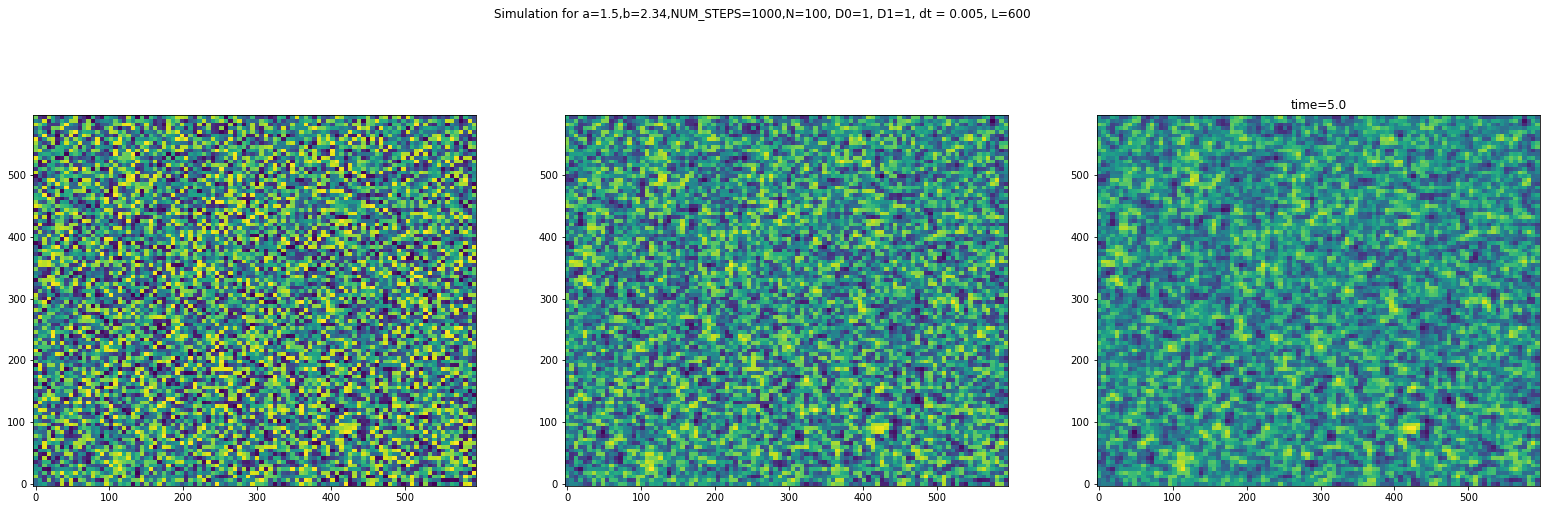

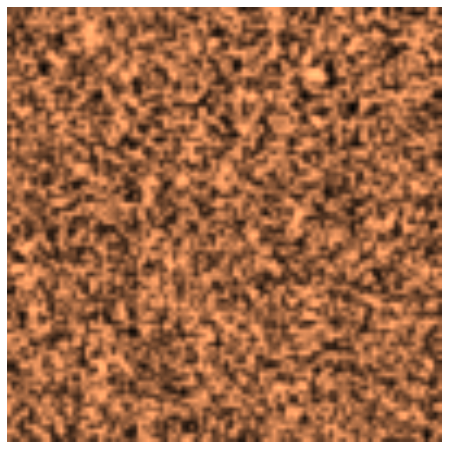

In [120]:
# simulate_and_plot(Brusselator())
a = 0
b = 0
# method = 'finite-difference'
method = 'pseudo-spectral'
bruss = Brusselator(NUM_STEPS=10**3, N=100,L=600, dt = 0.005, D0=1, D1=1, method=method)
bruss.fu = lambda u,v:0.0
bruss.fv = lambda u,v:0.0
simulate_and_plot(bruss)
# anim = run_animation(bruss)
# anim
# HTML(anim.to_jshtml())

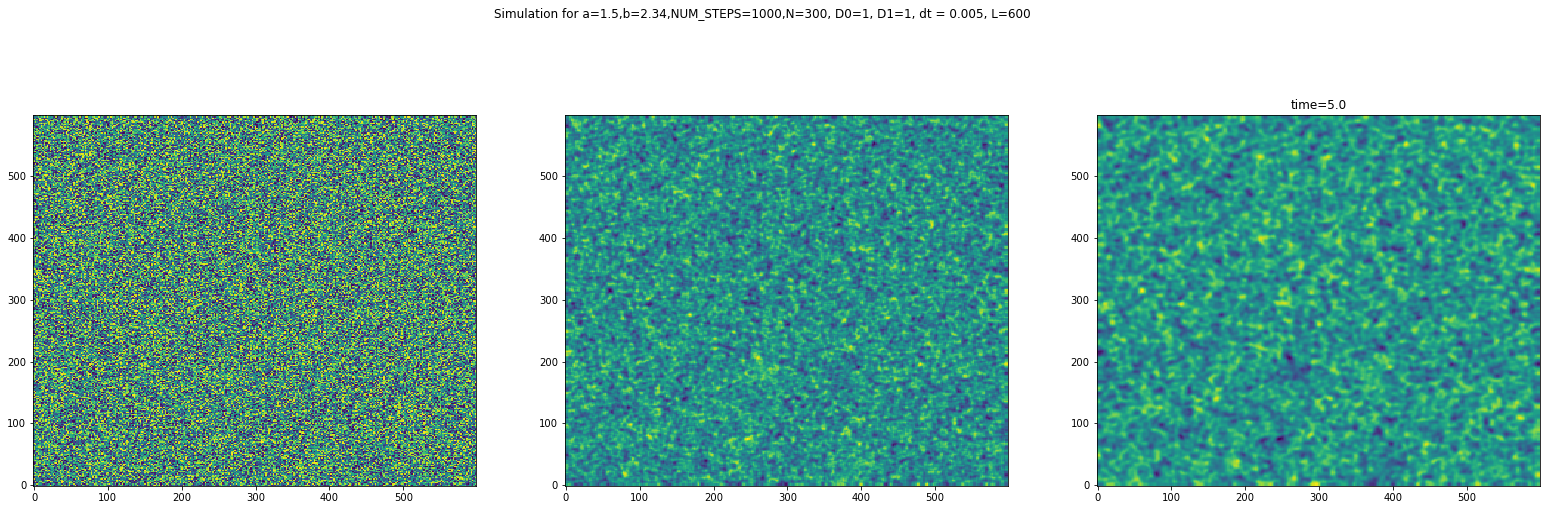

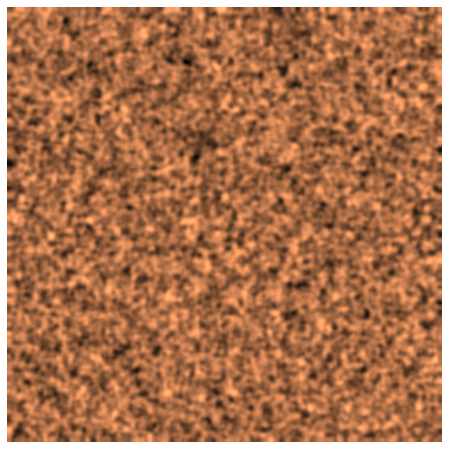

In [121]:
a = 0
b = 0
method = 'finite-difference'
# method = 'pseudo-spectral'
bruss2 = Brusselator(NUM_STEPS=10**3, N=300,L=600, dt = 0.005, D0=1, D1=1, method=method)
bruss.fu = lambda u,v:0.0
bruss.fv = lambda u,v:0.0
simulate_and_plot(bruss2)

In [122]:
# anim.save("faulty.gif", writer='imagemagick', fps=15)
# FFwriter = animation.FFMpegWriter(fps=10)
# anim.save('faulty.mp4', writer = FFwriter)

I got nice results for

N = 256

L = 20\pi

a=1.5

b=2.34

D0=2.8

D1 = 22.4

dt = 0.05

NUM_STEPS = 10**3

FOR 

N = 1200
a=1.5
b=2.34
D0=2.8
D1 = 22.4
dt = 0.05
NUM_STEPS = 10**3
Also interesting at least at time NUM_STEPS/2


Also interesting
N = 200
a=1.5
b=2.34
D0=2.8
D1 = 22.4
dt = 0.05
NUM_STEPS = 10**3

What do I want from the simulation?
I want to be able to change the parameters rather easily. Or display a bunch of plots 
What parameters do I have?